In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

In [7]:
masks = glob.glob("../data/Dataset_BUSI_with_GT/*/*_mask.png")

In [8]:
masks[1:4]

['../data/Dataset_BUSI_with_GT\\benign\\benign (10)_mask.png',
 '../data/Dataset_BUSI_with_GT\\benign\\benign (100)_mask.png',
 '../data/Dataset_BUSI_with_GT\\benign\\benign (101)_mask.png']

In [4]:
images = [mask_images.replace("_mask", "") for mask_images in masks]

In [5]:
    series = list(zip(images, masks))

In [6]:
series[:4]

[('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png'),
 ('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png'),
 ('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png'),
 ('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89).png',
  '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png')]

In [7]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])
    
    f, axarr = plt.subplots(1, 3, figsize=(5, 5))
    
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

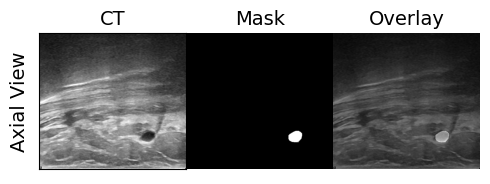

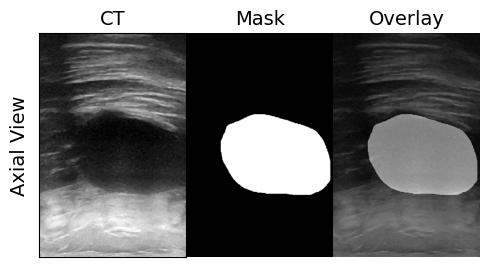

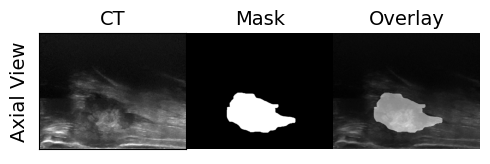

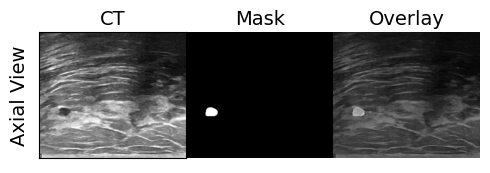

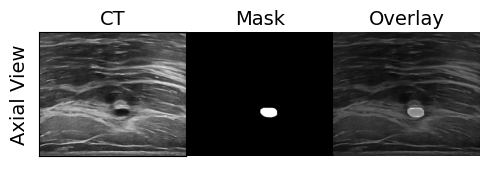

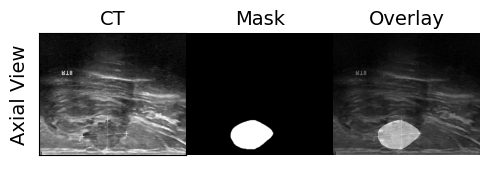

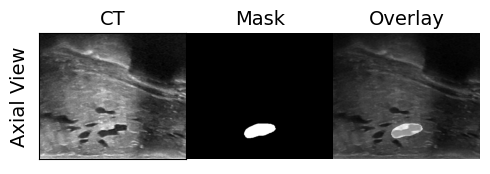

In [8]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [9]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])

In [10]:
dataset

,image_path,mask_path
0,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
1,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
2,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
3,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
4,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
...,...,...
775,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
776,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
777,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...
778,/kaggle/input/breast-ultrasound-images-dataset...,/kaggle/input/breast-ultrasound-images-dataset...


In [11]:
train, test= train_test_split(dataset, test_size=0.2)

In [12]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (624, 2)
Test shape: (156, 2)


In [13]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
torch.cuda.set_device(0)
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L') # I used RGB too, doesn't fix the problem
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            # Resize to 240*240 then transforming to Tensor
            image = self.image_transform(image) 
            mask = self.image_transform(mask)
        
        return image, mask

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize([240, 240]),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize([240, 240]),
    transforms.ToTensor()
])

# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

# Create DataLoaders
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [15]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    
    print(targets[0].shape)
    # Break the loop after printing the shapes of the first batch
    break

Input shape: torch.Size([8, 1, 240, 240])
Target shape: torch.Size([8, 1, 240, 240])
torch.Size([1, 240, 240])


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cuda', index=0)

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.gelu_1 = nn.ReLU()

        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.gelu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.gelu_1(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.gelu_2(x)

        return x

class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)

        return x, p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(output_channel*2, output_channel)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [19]:
class Unet(nn.Module):

    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64)
        self.encoder_2 = Encoder(64, 128)
        self.encoder_3 = Encoder(128, 256)
        self.encoder_4 = Encoder(256, 512)

        self.conv_block = ConvBlock(512, 1024)

        self.decoder_1 = Decoder(1024, 512)
        self.decoder_2 = Decoder(512, 256)
        self.decoder_3 = Decoder(256, 128)
        self.decoder_4 = Decoder(128, 64)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid() 

    def forward(self, x):

        """ ------ Encoder ------"""
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)

        """ ------ BottleNeck ------"""
        x5 = self.conv_block(p4)

        """ ------ Decoder ------"""
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)
        
        """ ------ Final Layer ------"""
        x_final = self.cls(x9)
        x_final = self.relu(x_final)

        return x_final


In [20]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 8

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)
    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
            'best_model': self.best_model,
            'best_dice': self.best_dice,
            'best_epoch': self.best_epoch
        }

In [21]:
def dice_coef_loss(inputs, target):
    smooth = 1e-5
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)
    
    return bce_score + dice_score

In [22]:
unet = Unet().to(device)

In [25]:
learning_rate = 0.0001
weight_decay = 1e-4  # Regularization term to prevent overfitting

optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer = Trainer(model=unet, num_epochs=40, optimizer=optimizer, criterion=bce_dice_loss, device=device)

In [26]:
trainer.train(train_dataloader, test_dataloader)
metrics = trainer.get_metrics()

Epoch [1/40], Step [8/78], Loss: 1.1825, Dice Coef: 0.1958
Epoch [1/40], Step [16/78], Loss: 1.1609, Dice Coef: 0.2850
Epoch [1/40], Step [24/78], Loss: 1.2545, Dice Coef: 0.1447
Epoch [1/40], Step [32/78], Loss: 1.1713, Dice Coef: 0.2426
Epoch [1/40], Step [40/78], Loss: 1.1601, Dice Coef: 0.2074
Epoch [1/40], Step [48/78], Loss: 1.1469, Dice Coef: 0.2722
Epoch [1/40], Step [56/78], Loss: 1.1255, Dice Coef: 0.2561
Epoch [1/40], Step [64/78], Loss: 0.9528, Dice Coef: 0.3406
Epoch [1/40], Step [72/78], Loss: 1.0456, Dice Coef: 0.2700
Epoch [1/40], Train Loss: 1.1283, Val Loss: 1.0277
Epoch [1/40], Train Dice: 0.2437, Val Dice: 0.2832
Epoch [2/40], Step [8/78], Loss: 0.9556, Dice Coef: 0.3382
Epoch [2/40], Step [16/78], Loss: 1.0938, Dice Coef: 0.2115
Epoch [2/40], Step [24/78], Loss: 1.0143, Dice Coef: 0.2889
Epoch [2/40], Step [32/78], Loss: 1.1937, Dice Coef: 0.1853
Epoch [2/40], Step [40/78], Loss: 1.0520, Dice Coef: 0.3108
Epoch [2/40], Step [48/78], Loss: 1.1545, Dice Coef: 0.1941


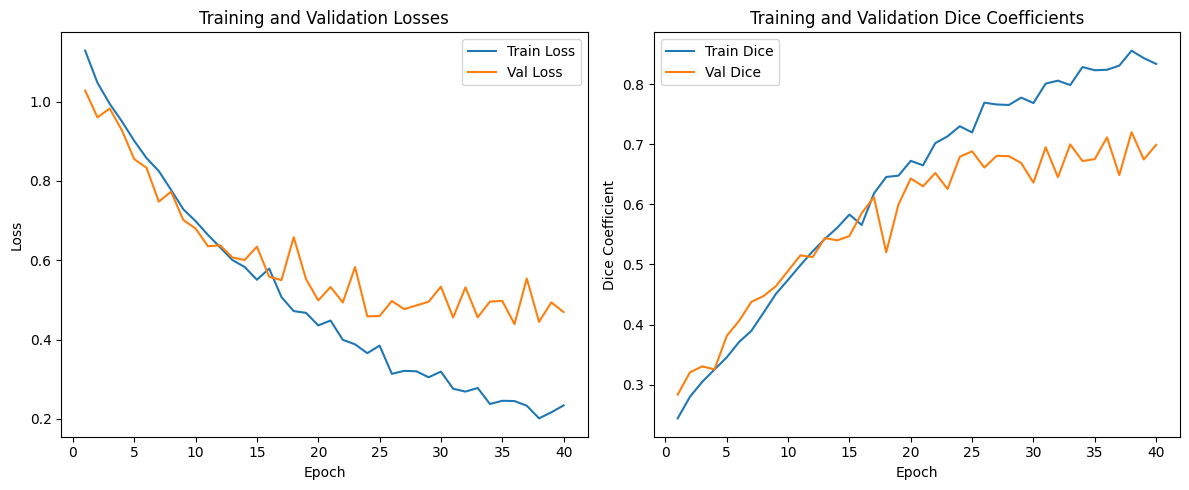

In [27]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


In [28]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def plot_subplots(image, mask, predicted):
    # Convert tensors to NumPy arrays
    image_np = to_numpy(image)
    image_np = image_np.squeeze()
    mask_np = to_numpy(mask)
    mask_np = mask_np.squeeze()
    predicted_np = to_numpy(predicted)

    fig, axes = plt.subplots(1, 3, figsize=(5, 3))

    # Plot Image
    axes[0].imshow(image_np)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Plot Mask
    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    # Plot Predicted
    axes[2].imshow(predicted_np, cmap='gray')
    axes[2].set_title('Predicted')
    axes[2].axis('off')

    plt.show()

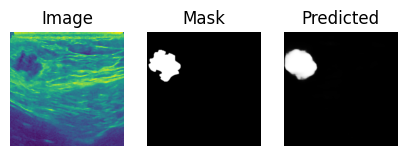

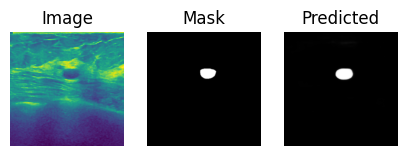

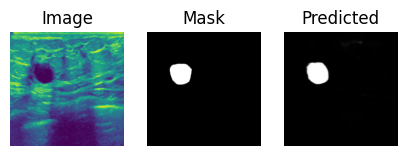

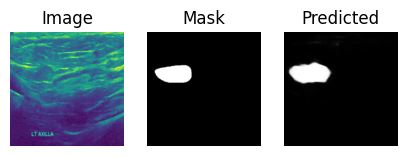

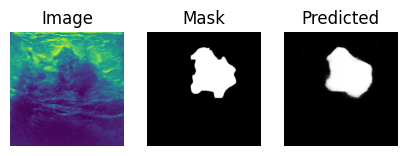

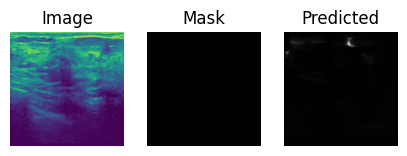

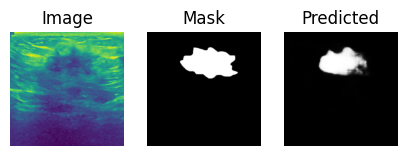

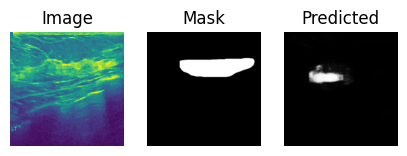

In [32]:
for i in [2, 3, 11, 20, 55, 66, 87, 98]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)